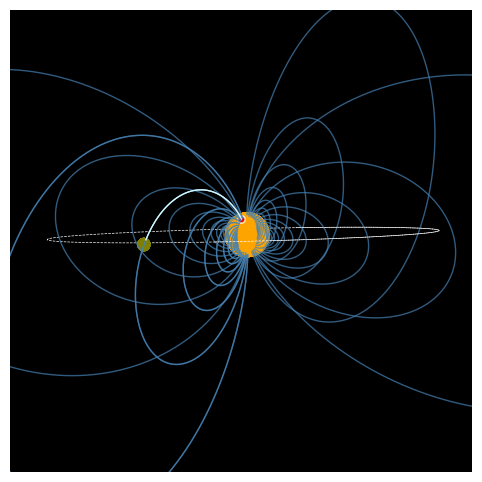

In [291]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Function to generate points for a sphere
def generate_sphere(radius=1, center=(0, 0, 0), resolution=50):
    u = np.linspace(0, 2 * np.pi, resolution)
    v = np.linspace(0, np.pi, resolution)
    x = center[0] + radius * np.outer(np.cos(u), np.sin(v))
    y = center[1] + radius * np.outer(np.sin(u), np.sin(v))
    z = center[2] + radius * np.outer(np.ones(np.size(u)), np.cos(v))
    return x, y, z

# Function to calculate the dipole field at a point
# The field is based on the magnetic dipole formula, which considers the
# position vector (x, y, z) relative to the dipole moment m. This implementation
# computes the field components Bx, By, and Bz based on the standard equations.
def dipole_field(x, y, z, m=(0, 0, 1)):
    r = np.sqrt(x**2 + y**2 + z**2)
    r5 = r**5
    dot_product = m[0] * x + m[1] * y + m[2] * z
    Bx = (3 * x * dot_product / r5) - m[0] / r**3
    By = (3 * y * dot_product / r5) - m[1] / r**3
    Bz = (3 * z * dot_product / r5) - m[2] / r**3
    return Bx, By, Bz

# Function to integrate field lines using Runge-Kutta method
# Field lines are computed by tracing the direction of the magnetic field vector
# at each point, normalized to prevent arbitrary step sizes. The function starts
# at an initial position (x0, y0, z0) and iteratively computes the next position
# based on the field direction. This approximates the path of field lines.
def integrate_field_line(x0, y0, z0, m, steps=1000, step_size=0.1):
    x, y, z = [x0], [y0], [z0]
    for _ in range(steps):
        Bx, By, Bz = dipole_field(x[-1], y[-1], z[-1], m)
        B_mag = np.sqrt(Bx**2 + By**2 + Bz**2)
        if B_mag == 0:
            break
        dx = step_size * Bx / B_mag
        dy = step_size * By / B_mag
        dz = step_size * Bz / B_mag

        # Prevent field lines from going inside the sphere
        next_x, next_y, next_z = x[-1] + dx, y[-1] + dy, z[-1] + dz
        if np.sqrt(next_x**2 + next_y**2 + next_z**2) < sphere_radius:
            break

        x.append(next_x)
        y.append(next_y)
        z.append(next_z)
    return np.array(x), np.array(y), np.array(z)

# Generate sphere data for the main sphere
sphere_radius = 1
sphere_x, sphere_y, sphere_z = generate_sphere(radius=sphere_radius)

# Generate dipole field lines
# Field lines are initialized at points on the surface of the main sphere.
# Each starting point corresponds to a specific position on the sphere surface,
# and the field lines are traced from these points using the integration function.
n_lines = 8
theta = np.linspace(0, 2 * np.pi, 5)
phi = np.linspace(0, 1, n_lines*2) * np.pi / 2 + np.pi / 14
m = (0, 0, 1)
field_lines = []
for t in theta:
    for p in phi:
        x0 = sphere_radius * np.sin(p) * np.cos(t)
        y0 = sphere_radius * np.sin(p) * np.sin(t)
        z0 = sphere_radius * np.cos(p)

        x, y, z = integrate_field_line(x0, y0, z0, m)

        # rotate the field line 20 deg in the x axis 
        # x' = x
        # y' = y * cos(20) - z * sin(20)
        # # z' = y * sin(20) + z * cos(20)
        # y = y * np.cos(np.deg2rad(20)) - z * np.sin(np.deg2rad(20))
        # z = y * np.sin(np.deg2rad(20)) + z * np.cos(np.deg2rad(20))

        # rotate the field line 15 deg in the y axis
        # x' = x * cos(15) + z * sin(15)
        # y' = y
        # z' = -x * sin(15) + z * cos(15)
        x = x * np.cos(np.deg2rad(15)) + z * np.sin(np.deg2rad(15))
        z = -x * np.sin(np.deg2rad(15)) + z * np.cos(np.deg2rad(15))

        field_lines.append((x, y, z))

# Order field lines by proximity to the viewer (in z-axis direction)
def sort_field_lines_by_z(field_lines):
    return sorted(field_lines, key=lambda line: np.mean(line[2]), reverse=True)

field_lines = sort_field_lines_by_z(field_lines)

# Position of the smaller sphere
small_sphere_center = (11.7, 1.35, 0.55)  # Closer to the equator of the main sphere
small_sphere_x, small_sphere_y, small_sphere_z = generate_sphere(radius=0.25, center=small_sphere_center)

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the main sphere
ax.plot_surface(sphere_x, sphere_y, sphere_z, color='orange', alpha=1, edgecolor='orange', zorder=0)

# Plot the field lines
for line in field_lines:
    x, y, z = line
    ax.plot(x, y, z, color='steelblue', alpha=0.7, zorder=10, lw=1)

    # if the line is close to the location of the smaller sphere, plot it in a different color
    if np.linalg.norm([x[len(x)//2], y[len(x)//2], z[len(x)//2]] - np.array(small_sphere_center)) < 4:
        cond = (z > 0.48) | ((x < 0.5) & (z > 0.5))
        ax.plot(x[cond], y[cond], z[cond], color='lightcyan', alpha=1, zorder=10, lw=0.8)

# Plot the smaller sphere
ax.plot_surface(small_sphere_x, small_sphere_y, small_sphere_z, color='lightcyan', edgecolor="olive", alpha=1, zorder=30)

# add a line along the z-axis
ax.plot([0, 0], [0, 0], [-2, 2], color='black', lw=.5)

# add an star to 1,1,1
ax.scatter([1], [0.2], [.8], color='moccasin', marker='o', s=30, zorder=6)
ax.scatter([1], [0.2], [.8], color='red', marker='o', s=10, zorder=6)

# plot a circle with radius 11 in the x-y plane
theta = np.linspace(0, 2 * np.pi, 100)
x = 7 * np.cos(theta)
y = 7 * np.sin(theta)
# z = np.sin(theta + np.pi/10)
z = np.zeros_like(x)

# now rotate the circle 30 deg in the x axis and 40 in the z axis
# x' = x

d1 = 0
d2 = 52.

# y' = y * cos(d1) - z * sin(d1)
# z' = y * sin(d1) + z * cos(d1)
y = y * np.cos(np.deg2rad(d1)) - z * np.sin(np.deg2rad(d1))
z = y * np.sin(np.deg2rad(d1)) + z * np.cos(np.deg2rad(d1))

# x' = x * cos(40) - y * sin(40)
# y' = x * sin(40) + y * cos(40)
x = x * np.cos(np.deg2rad(d2)) - y * np.sin(np.deg2rad(d2))

ax.plot(x, y, z, color='white', lw=.5, linestyle='dashed')

# for y>0 plot the circle with high zorder
ax.plot(x[y>0], y[y>0], z[y>0], color='white', lw=.5, linestyle='dashed', zorder=1000)


# Axis settings
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")
ax.set_zlabel("Z-axis")
r1 = 7
ax.set_xlim([-r1, r1])
ax.set_ylim([-r1, r1])
ax.set_zlim([-r1/2, r1/2])
ax.set_box_aspect([1, 1, 0.5])  # Aspect ratio

# rotate the plot
ax.view_init(elev=5, azim=28)

# turn off the axes and grid
ax.axis('off')

# make the background black
ax.set_facecolor('black')

# plt.show()

plt.savefig('../plots/paper/dipole_field_lines.png', dpi=300, bbox_inches='tight')